# Import The Relevant Libraries

In [1]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from sktime.classification.kernel_based import RocketClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import recall_score

import time

from math import ceil

# Obtain and Process Vast Data

In [2]:
t_data = pd.read_csv("All_Transient_Data.csv")

In [3]:
rel_data = t_data[["sbid","beam","name","PSR_Label"]]
rel_data.head()

,sbid,beam,name,PSR_Label
0,49588,beam00,J163259.92-501507.22,1
1,49588,beam00,J163048.20-491129.49,0
2,49588,beam04,J162710.82-481537.04,0
3,49588,beam05,J163250.42-482506.53,0
4,49588,beam06,J164019.07-490047.32,0


In [4]:
# Remove all null_values
rel_data = rel_data.dropna(how='any',axis=0)

In [5]:
rel_data["sbid"] = rel_data["sbid"].astype(str)

In [6]:
rel_data["lc_peakflux_path"] = "SB"+rel_data["sbid"]+"_"+rel_data["beam"]+"_lightcurve_peak_flux.csv"

In [7]:
lc_folder_name = "VAST 10s lightcurve"
avail_files = os.listdir(lc_folder_name)

match_files = []
for i in list(rel_data["lc_peakflux_path"].unique()):
    if i in avail_files:
        match_files.append(i)

In [8]:
# find limiting row size
seq_sizes = []
for file in match_files:
    pf_df = pd.read_csv(f"{lc_folder_name}/{file}")
    seq_len = pf_df.shape[0]
    seq_sizes.append(seq_len)
min_seq_size = min(seq_sizes)

# Obtain and Process The Unbalanced Dataframe

In [9]:
def normalise_signal(signal):
    """
    Applies min-max normalisation on an array or signal.

    Parameters
    ----------
    signal : list or numpy array
        A list or array of integers or floats.

    Returns
    -------
    signal : numpy array
        A min-max normalised numpy array
    """
    # Min-max normalisation so values are in between 0 and 1
    signal = np.array(signal)
    signal = (signal - signal.min())/ (signal.max() - signal.min())
    return signal

In [10]:
def obtain_data_seq(file_name, rel_data, lc_folder_name = "VAST 10s lightcurve", min_seq_size = 64):
    """
    Obtains the truncated sequences, targets and source information for each source
    in a light curve file.

    Parameters
    ----------
    file_name : str
        The name of the file with it's extension.

    rel_data : pandas dataframe
        The dataframe containing the relevant features and
        associated peak flux light curve paths.

    lc_folder_name : str, default "VAST 10s lightcurve"
        The path to the light curve folder

    min_seq_size : int, default = 64
        The minimum length of the sequences which restricts how large
        the other sequences can be.

    Returns
    -------
    sequences : list
        List of all the obtained light curves.

    targets : list
        List of all the obtained light curve labels.

    src_names : list
        List of all the obtained source information for the light curves.
    """
    pf_df = pd.read_csv(f"{lc_folder_name}/{file_name}")
    
    split_file = file_name.split("_")
    sbid = split_file[0][2:]
    beam_id = split_file[1]
    sequences = []
    src_names = []
    targets = []
    for src in pf_df.columns[1:]:
        label = rel_data[(rel_data["name"] == src) & (rel_data["sbid"] == sbid) & (rel_data["beam"] == beam_id)]["PSR_Label"].values
        # Need to denoise the signals
        val = pf_df[src].values
        
        # Need to normalise row values
        val = normalise_signal(val)
        # truncate the rows so all rows are the same size
        val = val[:min_seq_size]
        val = list(val)
        targets.append(label[0])
        src_names.append(f"{sbid}_{beam_id}_{src}")
        sequences.append(val)

    return sequences, targets, src_names

In [11]:
all_sequences = []
all_targets = []
all_src_names = []
for file in match_files:
    sequences, targets, src_names =  obtain_data_seq(file, rel_data, min_seq_size = min_seq_size)
    all_sequences.extend(sequences)
    all_targets.extend(targets)
    all_src_names.extend(src_names)

In [12]:
seq_array = np.array(all_sequences)
target_array = np.array(all_targets)
src_array = np.array(all_src_names)

In [13]:
target_array = target_array[~np.isnan(seq_array).any(axis=1)]
src_array = src_array[~np.isnan(seq_array).any(axis=1)]
seq_array = seq_array[~np.isnan(seq_array).any(axis=1),:]

In [14]:
# Check for nan values
np.argwhere(np.isnan(seq_array))

array([], shape=(0, 2), dtype=int64)

In [15]:
np.unique(target_array, return_counts=True)

(array([0, 1], dtype=int64), array([2274,  251], dtype=int64))

# Balance The Dataframe

In [16]:
# Obtain all the sequences corresponding to a transient
t_seq_array = seq_array[target_array == 1, :]
t_src_array = src_array[target_array == 1]
n_samples = t_seq_array.shape[0]

In [17]:
# Obtain all the sequences corresponding to a non-transient
f_seq_array = seq_array[target_array == 0, :]
f_src_array = src_array[target_array == 0]

In [18]:
n_samples

251

In [19]:
# Randomly choose indices from sequences where target is 0
f_seq_idx = np.array(range(f_seq_array.shape[0]))
f_chosen_idx = f_seq_idx[np.random.choice(f_seq_idx.shape[0], n_samples, replace=False)]

In [20]:
reduced_f_seq_array = f_seq_array[f_chosen_idx,:]
reduced_f_src_array = f_src_array[f_chosen_idx]

In [21]:
# Concatenate the balanced sequences together
final_seq_array = np.concatenate((reduced_f_seq_array, t_seq_array), axis=0)
final_src_array = np.concatenate((reduced_f_src_array, t_src_array), axis=0)
final_targets = np.array([0]*reduced_f_seq_array.shape[0]+[1]*t_seq_array.shape[0])

In [22]:
# Use the indices of the sequences, sources and targets as a reliable means of shuffling them
final_idx = np.array(range(final_seq_array.shape[0]))
# Shuffle the indices
final_idx = final_idx[np.random.choice(final_idx.shape[0], len(final_idx), replace=False)]

In [23]:
final_seq_array = final_seq_array[final_idx, :]
# Use 3D numpy array for rocket classifier since this is a valid mtype
final_seq_array_3D = final_seq_array[:, np.newaxis, :]
final_src_array = final_src_array[final_idx]
final_targets = final_targets[final_idx]

62025_beam11_J163725.49-505309.28


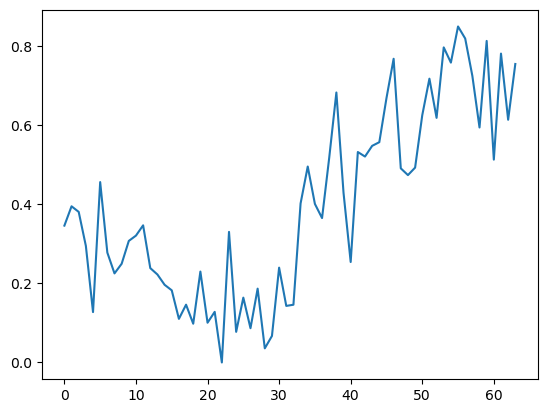

In [24]:
# Examine one of the light curves to see if it matches what we expect
print(final_src_array[0])
plt.plot(list(range(min_seq_size)), final_seq_array[0])
plt.show()

# Split The Data into Training and Test Sets

In [25]:
def train_test_split(sequences, targets, src_array, train_prop = 0.7):
    """
    Splits the sequences, targets and source information into training
    and testing data according to a particular proportion.

    Parameters
    ----------
    sequences : numpy array
        The lightcurves that are going to be split.

    targets : numpy array
        The labels that are going to be split.

    src_array : numpy array
        The source information that is going to be split.

    train_prop : float, default 0.7
        The proportion of the light curves and labels in
        the training set.

    Returns
    -------
    train_sequences : numpy array
        The light curves in the training set.

    test_sequences : numpy array
        The light curves in the test set.

    train_targets : numpy array
        The labels in the training set.

    test_targets : numpy array
        The labels in the test set.

    train_info : numpy array
        The source information in the training set.

    test_info : numpy array
        The source information in the test set.
    """
    # Obtain the number of training samples
    n_train = round(sequences.shape[0] * train_prop)

    # Obtaining train and test sequences
    train_sequences = sequences[:n_train+1,:]
    test_sequences = sequences[n_train+1:,:]

    # Obtaining train and test targets
    train_targets = targets[:n_train+1]
    test_targets = targets[n_train+1:]

    # Obtain train and test source info
    train_info = src_array[:n_train+1]
    test_info = src_array[n_train+1:]

    return train_sequences, test_sequences, train_targets, test_targets, train_info, test_info

In [26]:
# Obtain train, test split
train, test, train_targets, test_targets, train_info, test_info = train_test_split(final_seq_array_3D, final_targets, 
                                                                                                       final_src_array, train_prop = 0.7)

In [27]:
np.unique(test_targets, return_counts = True)

(array([0, 1]), array([72, 78], dtype=int64))

# Implementing Rocket Classifier

ROCKET (Random Convolutional Kernel Transform) involves using randomly sized kernels or filters to extract features from time series data. These extracted features are then fed into a classifier such as the RidgeClassifierCV in the case of sktime's RocketClassifier function. Ridge classifiers combine classification with Ridge Regression (also known as L2 Regularisation) which is used to reduce overfitting.

MiniROCKET is a faster alternative to ROCKET that uses small fixed kernels and proportion of positive value pooling to extract features from time series data.

__Further information on the RocketClassifier can be found in the sktime documentation:__ 
Author Unknown, *RocketClassifier*, retrieved 08/01/2025 from sktime documentation, https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.classification.kernel_based.RocketClassifier.html

__The information on Ridge Classification was found from:__
Kavlakoglu E. and Murel J., *What is ridge regression?* retrieved 08/01/2025 from IBM, https://www.ibm.com/think/topics/ridge-regression#:~:text=Ridge%20regression%E2%80%94also%20known%20as,for%20multicollinearity%20in%20regression%20analysis.

__The information on ROCKET was found from:__
Chavan J. (02/09/2023), *From Data to Insights: ROCKET’s Journey in Time Series Analysis* retrieved 08/01/2025 from IBM, https://medium.com/@anuj_chavan/from-data-to-insights-rockets-journey-in-time-series-analysis-6f42ae8cfe7d

__The information on MiniROCKET was found from:__
Author Unknown, *MiniRocket*, retrieved 08/01/2025 from sktime documentation, https://www.sktime.net/en/stable/examples/transformation/minirocket.html

The number of kernals chosen for the MiniRocket Classifier was obtained from __*"Guglielmo, G., Klincewicz, M., Veld, E., & Spronck, P. (2024). Detecting Experts Using a MiniRocket: Gaze Direction Time Series Classification of Real-Life Experts Playing the Sustainable Port. In Games and Learning Alliance: 13th International Conference, GALA 2024, Berlin, Germany, November 20–22, 2024, Proceedings (pp. 177–187). Springer-Verlag."*__ 

In [28]:
start = time.time()
rocket = RocketClassifier(num_kernels = 9996, rocket_transform = "minirocket")
rocket.fit(train, train_targets)
end = time.time()

dur = end - start
print(dur)

4.625732421875


Rocket model fitting takes approximately 11 s.
Minirocket model fitting takes approximately 4 s.

In [29]:
test_pred = rocket.predict(test)

In [30]:
accuracy_score(test_targets, test_pred)

0.9533333333333334

# Model Evaluation

In [31]:
from sklearn import metrics

# Create a confusion matrix based on the predicted labels and test labels
confusion_matrix = metrics.confusion_matrix(test_targets,test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

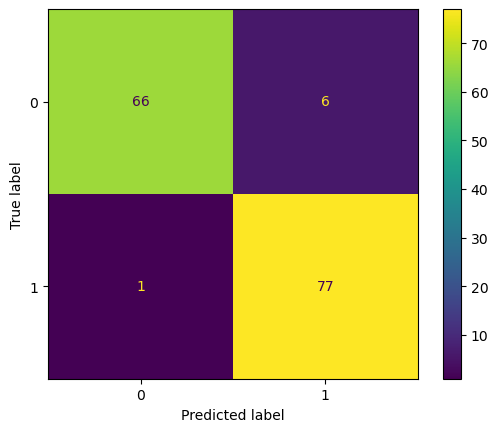

In [32]:
import matplotlib.pyplot as plt
cm_display.plot()
plt.show()

In [33]:
# Compare 5 and 10 splits
np.mean(cross_val_score(rocket, train, y=train_targets, cv=KFold(n_splits=5)))

0.9120724346076459

In [34]:
# Obtain recall score for detected transients
recall_score(test_targets, test_pred, average="binary", zero_division=1)

0.9871794871794872

This MiniRocket classifier shows consistently high average cross validation and recall score with values above 90% for each which should be effective for detecting transients.

# Save The Model

In [35]:
from sktime.utils import mlflow_sktime

In [36]:
# IMPORTANT: You must delete the existing 'Rocket_Model' folder before you can save the new model
model_path = "Models"
if "Rocket_Model" not in os.listdir(model_path) :
    mlflow_sktime.save_model(  
        sktime_model=rocket,
        path=f"{model_path}/Rocket_Model")

### Finding The False Positives

In [37]:
# False positives are sources which are not transients but are predicted to be transients by the classifier
fp_idx = (test_targets != test_pred) & (test_targets == 0)

In [38]:
test_info[fp_idx][0]

'60804_beam27_J183235.19-090547.27'

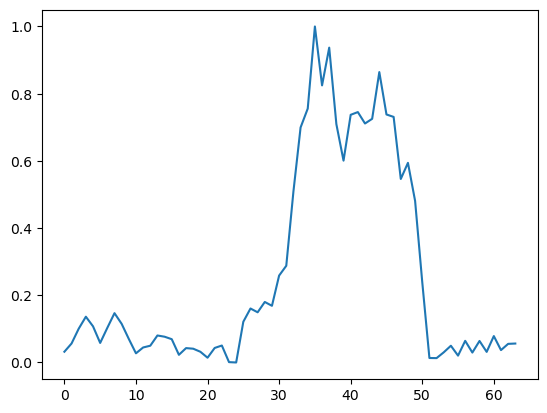

In [39]:
# Examining the light curve of a false positive
if len(test[fp_idx]) != 0:
    plt.plot(list(range(min_seq_size)),test[fp_idx][0,0,:])
    plt.show()

In [40]:
def obtain_feature_df(all_src_info, t_data, features):
    """
    Obtain a dataframe with all the relevant feature data
    from the given source information.

    Parameters
    ----------
    all_src_info : numpy array
        The given source information with each source's sbid, beam and name combined.

    t_data : pandas dataframe
        Dataframe containing all the feature data.

    features : list
        List of strings containing the relevant features.

    Returns
    -------
    feature_df : pandas dataframe
        A dataframe that only contains the relevant features of the given source information.
    """
    # Finding feature values for data
    feature_arr = []
    
    for src_info in all_src_info:
        sbid, beam, name = src_info.split("_")
        feature_vals = t_data[(t_data["name"] == name) & (t_data["beam"] == beam) & (t_data["sbid"] == int(sbid))][features].values[0]
        feature_arr.append(feature_vals)

    feature_arr = np.array(feature_arr)
    feature_df = pd.DataFrame(data = feature_arr, columns = features)
    return feature_df

In [41]:
features = ['chi_square', 'chi_square_sigma', 'peak_map', 'peak_map_sigma','md_deep', 'deep_sep_arcsec', 
                'deep_num', 'bright_sep_arcmin', 'beam_sep_deg', 'deep_peak_flux', 'deep_int_flux','std_map']
feature_df = obtain_feature_df(test_info, t_data, features)

In [42]:
feature_df.head()

,chi_square,chi_square_sigma,peak_map,peak_map_sigma,md_deep,deep_sep_arcsec,deep_num,bright_sep_arcmin,beam_sep_deg,deep_peak_flux,deep_int_flux,std_map
0,243.946274,inf,19.377392,19.160543,0.145675,0.871196,2.0,0.014520,0.755183,0.911301,0.951305,0.072353
1,13.386281,25.844184,5.862255,5.114202,0.109133,7.899016,1.0,0.131650,0.733924,0.092623,0.096659,0.005698
2,8.122897,18.123356,6.248226,5.557292,0.513227,0.660471,1.0,10.222302,0.520285,0.020812,0.021386,0.008007
3,6.377954,15.641211,6.200208,5.493198,0.067602,9.231821,1.0,0.153864,0.835924,0.168018,0.185398,0.005399
4,4.001183,10.527183,4.469766,3.459935,2.437390,249.785510,0.0,23.769461,0.460910,0.001704,0.002090,0.003313


### Plot Features Against deep_sep_arcsec

In [43]:
def plot_all_against(feature_df, features, labels, x_feature = "deep_sep_arcsec", fol = "Plots", pred = 1):
    """
    Plot each feature against a particular feature such as "deep_sep_arcsec".
    The plots will be on a log-log axis with the colour of the labels being
    determined by the labels of the candidates.

    The code was adapted from JohanC's response to a stackoverflow question: 
    Creating Subplots inside a loop, generating Seaborn scatterplots (19/02/2024), 
    retrieved on 03/12/2024 from, 
    https://stackoverflow.com/questions/78021854/creating-subplots-inside-a-loop-generating-seaborn-scatterplots

    Parameters
    ----------
    balanced_t_data : pandas dataframe
        Dataframe containing data balanced by the number of each label.

    featuers : list
        The y axis features which you wish to plot against the x_feature.

    x_feature : str
        A selected feature for the x axis that stays the same in every plot.

    fol : str, default "Plots"
        The folder to store the plots.

    pred : int, default 1
        Determines which file to save the image to. If pred is 1 then the candidate's points
        were coloured using the MiniRocket predictions. If pred is 0 then the candidate's points
        were coloured using their actual labels. If pred is another value then candidate's points
        were coloured using both the labels obtained from the confusion matrix.
    """
    x_final = feature_df[x_feature]
    fig, axs = plt.subplots(nrows=len(features), figsize=(8, 4*len(features)))
    for ax, f in zip(axs.flat, features):
        sns.scatterplot(x=x_final, legend=f==features[0],
                        y=feature_df[f], hue=labels, ax=ax)
        ax.set_title(f"{f} vs. {x_feature}")
        if f==features[0]: # create a legend only for the first plot
            sns.move_legend(ax, loc='upper left', bbox_to_anchor=(1.05, 1.02))
        ax.set_xscale("log")
        ax.set_yscale("log")
    plt.tight_layout()
    plt.show()
    if pred == 1:
        fig.savefig(f"{fol}/Plot_of_Important_Features_MiniRocket.png")
    elif pred == 0:
        fig.savefig(f"{fol}/Plot_of_Important_Features_Actual.png")
    else:
        fig.savefig(f"{fol}/Plot_of_Important_Features_Actual_and_MR.png")

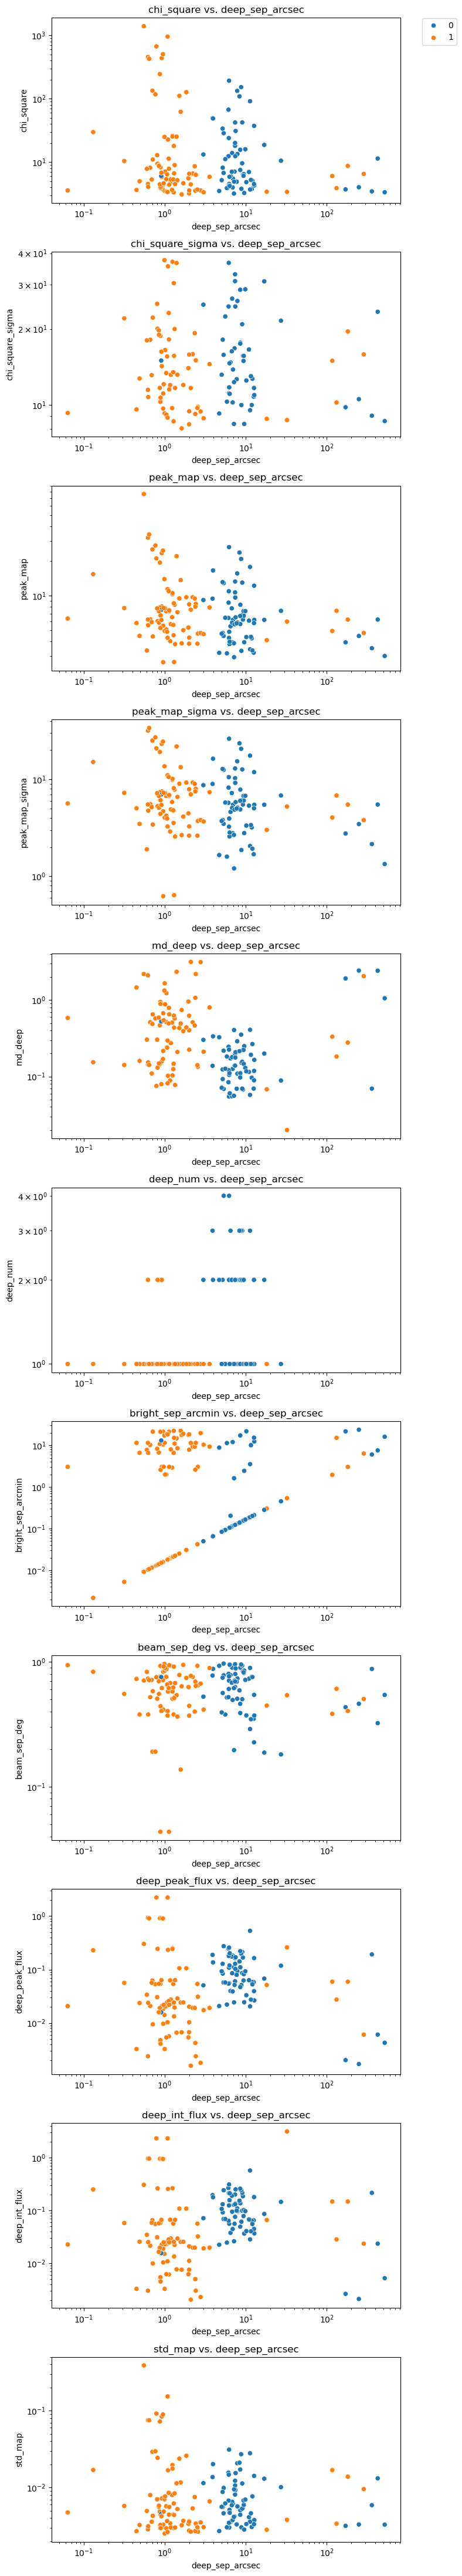

In [44]:
features_exclude_dsa = [f for f in features if f != "deep_sep_arcsec"]
plot_all_against(feature_df, features_exclude_dsa, test_pred, pred = 1)

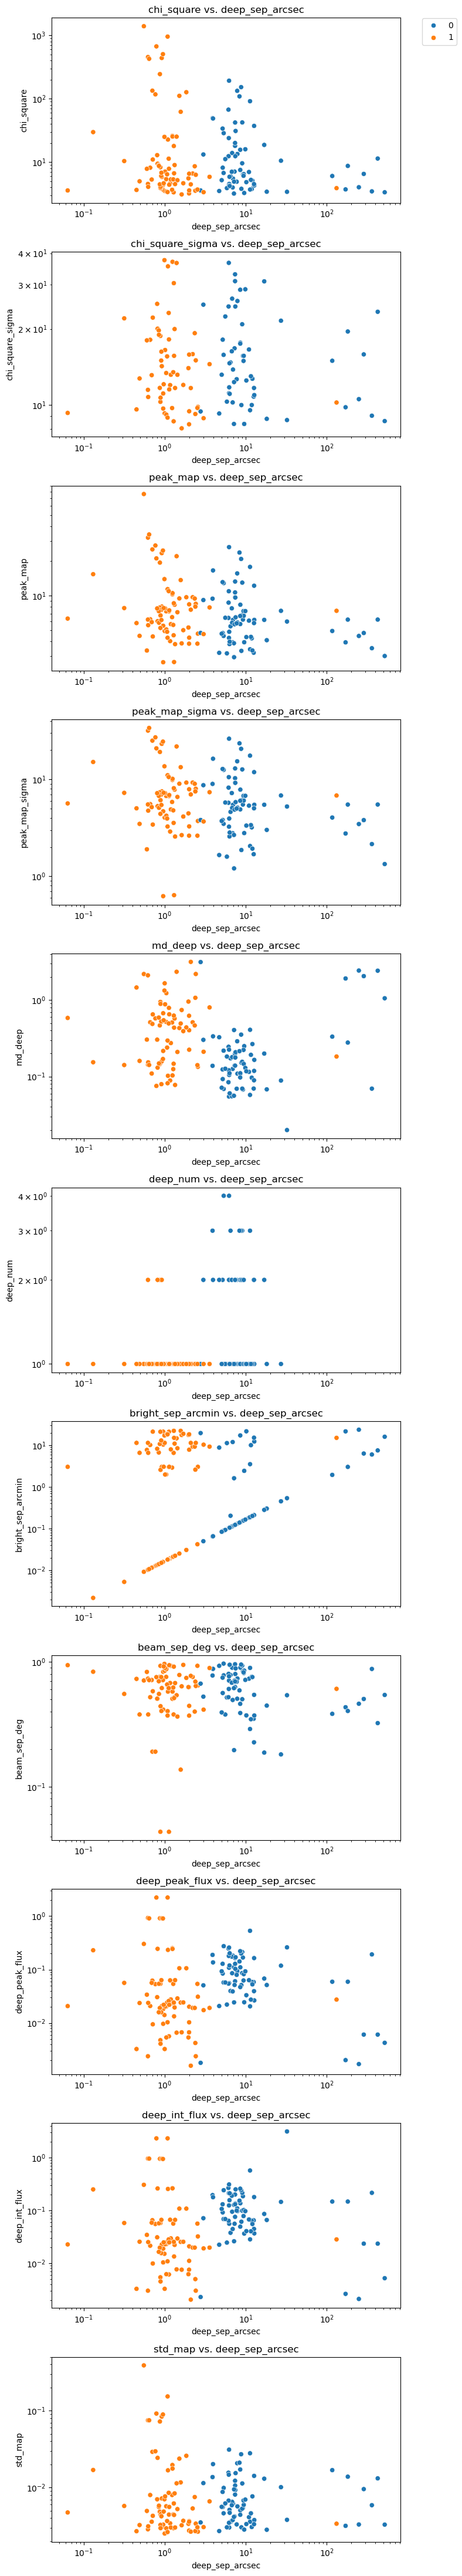

In [45]:
plot_all_against(feature_df, features_exclude_dsa, test_targets, pred = 0)

In [46]:
# Obtain the TP, FP, TN, FN labels for the minirocket model's confusion matrix of the test predictions
mr_and_act_labels = []
for i, val in enumerate(test_pred):
    if val == 1 and test_targets[i] == 1:
        mr_and_act_labels.append("TP")
    elif val == 1 and test_targets[i] != 1:
        mr_and_act_labels.append("FP")
    elif val == 0 and test_targets[i] == 1:
        mr_and_act_labels.append("FN")
    else:
        mr_and_act_labels.append("TN")

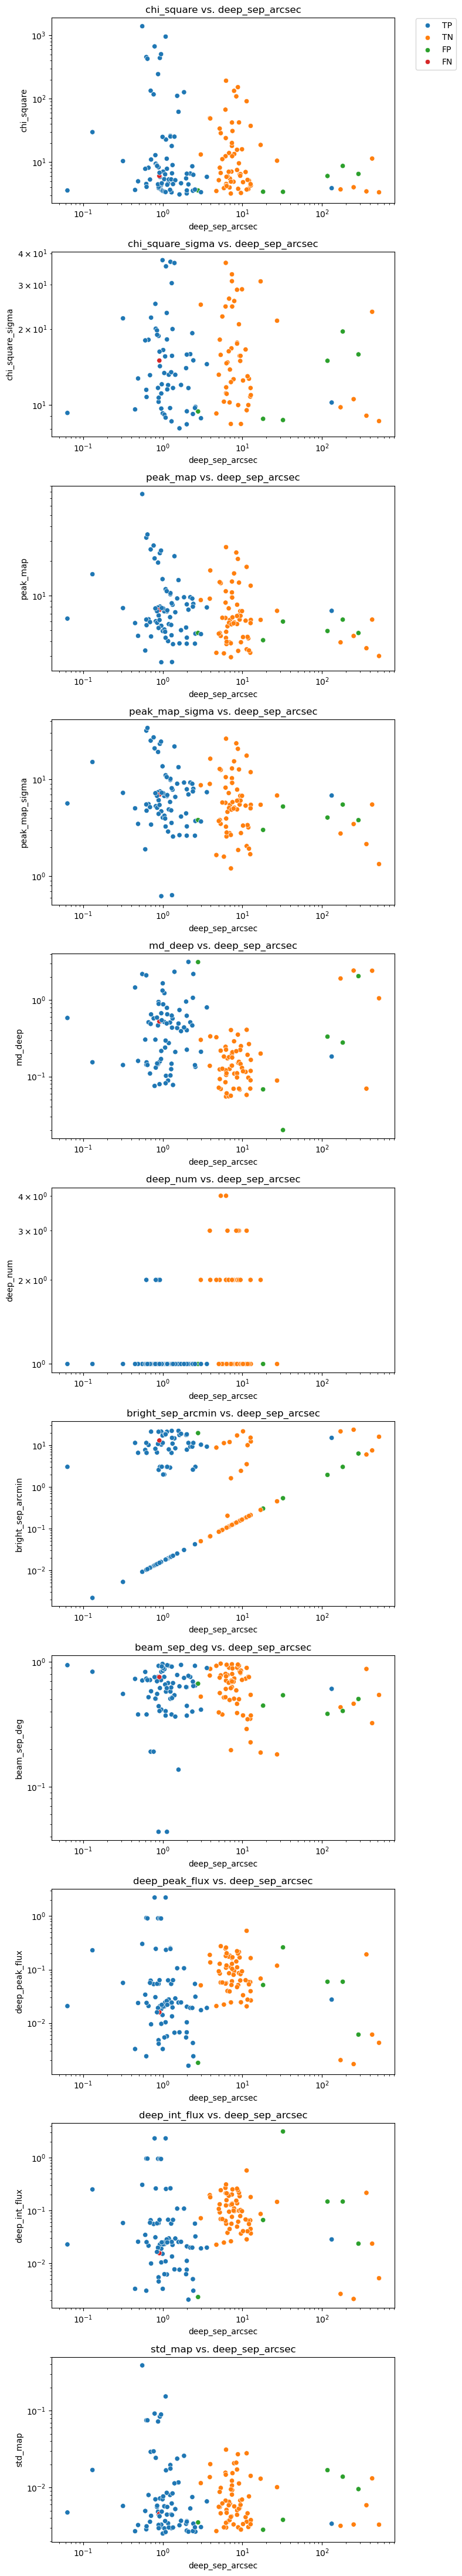

In [47]:
plot_all_against(feature_df, features_exclude_dsa, mr_and_act_labels, pred = 3)

# Further Tests and Analysis

### Analysing Outlier: SBID: "SB62644", Beam ID: "beam19", Name: "J183248.46-091115.92"

In [48]:
# Obtain the index of the outlier if it is in the source info
src = "62644_beam19_J183248.46-091115.92"
idx = None
for i, src_info in enumerate(test_info):
    if src in src_info:
        print(src_info)
        idx = i
        
if idx != None:
    print(test_pred[idx])
    print(test_targets[idx])

In [49]:
t_data[t_data["name"] == "J183248.46-091115.92"]["deep_sep_arcsec"]

7522    241.132978
Name: deep_sep_arcsec, dtype: float64

MiniRocket is capable of predicting one of the outliers that was present in the decision tree classifier. This outlier had a particular large deep_sep_arcsec compared to the other labelled transients hence making it difficult for the decision tree classifier to classify.

### Plot The False Positives

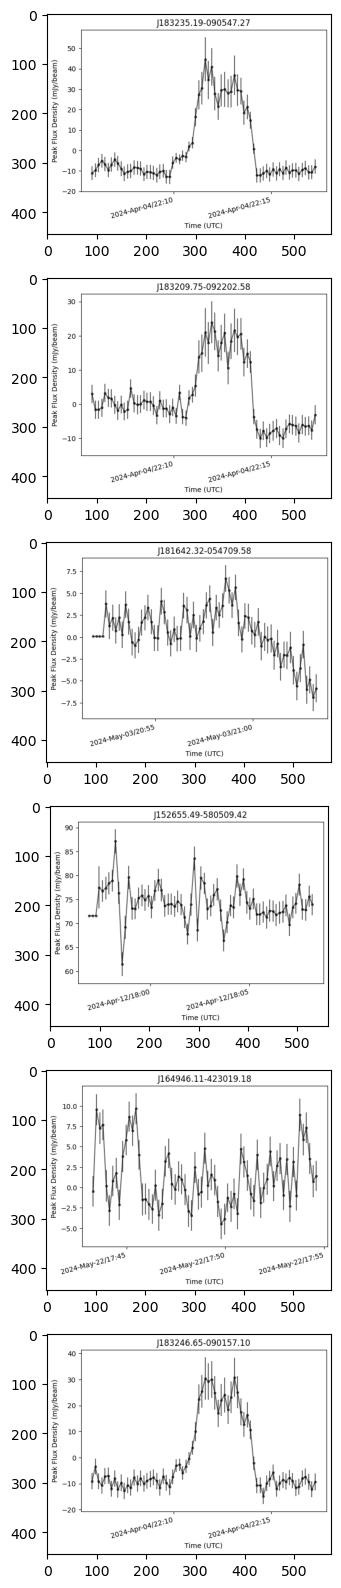

In [50]:
# Plot the light curves of the false positives 
lc_fol_name = 'VAST 10s lightcurve'
mr_and_act_labels = np.array(mr_and_act_labels)
rel_src_ls = test_info[mr_and_act_labels == 'FP']

fig, ax = plt.subplots(len(rel_src_ls),1, figsize = (20,20))
for i in range(len(rel_src_ls)):
    src_info = rel_src_ls[i]
    sbid, beam, name = src_info.split('_')
    f_path = f"{lc_fol_name}/SB{sbid}_{beam}_lightcurve_{name}.png"
    img = plt.imread(f_path)
    ax[i].imshow(img)

plt.show()

### Examine the False Positives

In [51]:
from astropy.io import fits

filename = 'VAST 10s fitscube/SB61530_beam35_slices_J182022.17-111124.89.fits'
hdu = fits.open(filename)

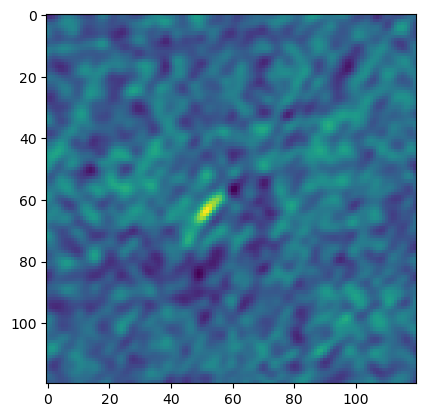

In [52]:
data = hdu[0].data
plt.imshow(data[-1])

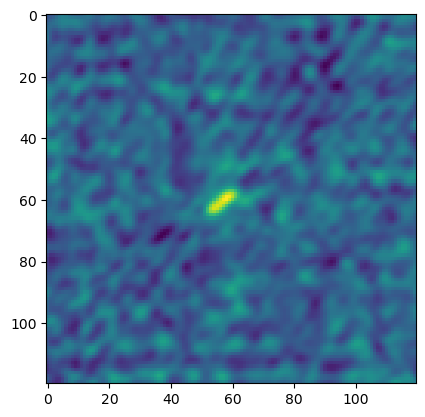

In [53]:
plt.imshow(data[0])

This false positive example appears to be a continuous source which moves significantly over the observation period. Since the light curves are of the central pixel, if the source moves away from the centre then returns, the brightness at the centre would fluctuate and the lightcurves would appear similar to that of a transient source.

A possible way to alleviate this would be to obtain the light curves of a large group of pixels around the central region and averaging them. Then these light curves would be fed into the MiniRocket classifier. Another method would be to track the movement of the source and its positions however this approach may be too specific to this particular artefact and may not be useful in addressing other artefacts that appear as false positives or false negatives.